In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile


def unzip(nm):
    with ZipFile(nm,"r") as zip:
        zip.extractall()

unzip("archive.zip")

random.seed(123)
np.random.seed(123)
tf.random.set_seed(123)

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "TB_Chest_Radiography_Database",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


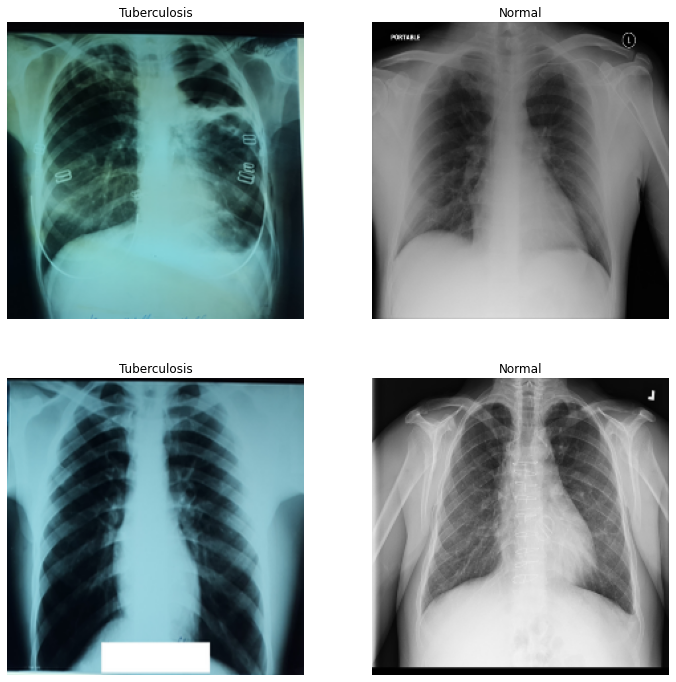

In [3]:
from tensorflow.data.experimental import cardinality

val_batches = cardinality(val_ds)
test_ds = val_ds.take(val_batches//5)
val_ds = val_ds.skip(val_batches//5)

class_names = train_ds.class_names

plt.figure(figsize=(12,12))
for images,labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

In [4]:
from tensorflow.keras.layers import RandomZoom, RandomRotation

data_augmentation = tf.keras.Sequential([
	RandomZoom(0.2),
    RandomRotation(0.1),
])

### Model: CNN from Scratch

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


class Tuber():
    def model(self,input):
        self.x = data_augmentation(input)
        self.x = Rescaling(1./255)(self.x)
        self.x = Conv2D(64,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = MaxPooling2D()(self.x)
        self.x = Conv2D(128,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = Conv2D(128,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = Conv2D(256,3,activation="relu",padding="same",strides=(2,2))(self.x)
        self.x = MaxPooling2D()(self.x)
        self.x = Flatten()(self.x)
        self.x = Dense(128,activation="relu")(self.x)
        self.x = Dropout(0.2,seed=123)(self.x)
        self.x = Dense(64,activation="relu")(self.x)
        self.x = Dropout(0.2,seed=123)(self.x)
        self.outputs = Dense(2,activation="sigmoid")(self.x)
        self.model = Model(input,self.outputs,name="Tuber")
        return self.model

tuber = Tuber()
model = tuber.model(Input(shape=(224,224,3)))
model.summary()
model.compile(RMSprop(),SparseCategoricalCrossentropy(),metrics=["accuracy"])

Model: "Tuber"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584

### Train and evaluate the model

In [6]:
if __name__=="__main__":
    initial_epochs = 50
    loss0,accuracy0 = model.evaluate(val_ds)
    checkpoint = ModelCheckpoint("tuberculosis.hdf5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=initial_epochs,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("tuberculosis.hdf5")
    val_loss,val_accuracy = best.evaluate(val_ds)
    test_loss,test_accuracy = best.evaluate(test_ds)
    print("\nVal accuracy: {:.2f} %".format(100*val_accuracy))
    print("Val loss: {:.2f} %".format(100*val_loss))
    print("\nTest accuracy: {:.2f} %".format(100*test_accuracy))
    print("Test loss: {:.2f} %".format(100*test_loss))

22/22 [==============================] - 3s 35ms/step - loss: 0.7080 - accuracy: 0.1721
Epoch 1/50
105/105 [==============================] - 9s 67ms/step - loss: 0.4680 - accuracy: 0.8318 - val_loss: 0.2584 - val_accuracy: 0.9000
Epoch 2/50
105/105 [==============================] - 8s 70ms/step - loss: 0.4318 - accuracy: 0.8589 - val_loss: 0.2113 - val_accuracy: 0.8971
Epoch 3/50
105/105 [==============================] - 8s 71ms/step - loss: 0.2942 - accuracy: 0.8920 - val_loss: 0.1762 - val_accuracy: 0.9206
Epoch 4/50
105/105 [==============================] - 8s 72ms/step - loss: 0.5842 - accuracy: 0.8833 - val_loss: 0.2132 - val_accuracy: 0.9074
Epoch 5/50
105/105 [==============================] - 8s 74ms/step - loss: 0.3159 - accuracy: 0.8976 - val_loss: 0.2085 - val_accuracy: 0.9088
Epoch 6/50
105/105 [==============================] - 8s 74ms/step - loss: 0.2124 - accuracy: 0.9161 - val_loss: 0.1943 - val_accuracy: 0.9118
Epoch 7/50
105/105 [==============================] - 